<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 4*

# 📝 Assignment
---

# 모델선택(Model Selection)

### 1) 캐글 대회를 이어서 진행합니다. RandomizedSearchCV 를 사용하여 하이퍼파라미터 튜닝을 진행합니다.

- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)를 사용하세요.
- 분류문제에서 맞는 [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) metric을 사용하세요.
- [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) 사용을 권합니다.
- RandomizedSearchCV 를 사용해서 하이퍼파라미터 튜닝을 진행하고 최고 성능을 보이는 모델로 예측을 진행한 후 캐글에 제출합니다.
- **캐글 Leaderboard에서 개선된 본인 Score를 과제 제출폼에 제출하세요.**

In [38]:
# 라이브러리 import

import pandas as pd
import numpy as np

import warnings 
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from category_encoders import CatBoostEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint, uniform

import matplotlib.pyplot as plt

In [2]:
### 이곳에서 과제를 진행해 주세요 ### 


# 데이터 불러오기
url_train = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/train.csv"
url_train_labels="https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/train_labels.csv"
url_test = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/test.csv"
url_submission = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/submission.csv"

target = 'vacc_h1n1_f'


train_raw = pd.merge(pd.read_csv(url_train),
                 pd.read_csv(url_train_labels)[target],
                left_index=True, right_index=True)


# train / val 데이터 나누기

from sklearn.model_selection import train_test_split

train, val = train_test_split(train_raw, train_size = 0.8, test_size = 0.2,
                             stratify = train_raw[target], random_state = 2)

In [3]:
import numpy as np

def engineer(df):
    
#     duplicate = df[df.duplicated(keep='last')]
#     df.drop(duplicate.index, inplace=True)
    
    # behavior 관련 특성 묶어서 새로운 특성 만들기
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behavior'] = df[behaviorals].sum(axis=1)
    
    # opinion 관련 특성 ordinal data로 바꾸기
    df['opinion_h1n1_vacc_effective'].replace({'Not At All Effective' : 0,
                                             'Not Very Effective' : 1,
                                             'Dont Know' : 2,
                                             'Refused' : 3,
                                             'Somewhat Effective' : 4,
                                             'Very Effective' : 5},
                                            inplace=True)
    df['opinion_h1n1_risk'].replace({'Very Low' : 0,
                                   'Somewhat Low' : 1,
                                   'Dont Know' : 2,
                                   'Refused' : 3,
                                   'Somewhat High' : 4,
                                   'Very High' : 5},
                                  inplace = True)
    df['opinion_h1n1_sick_from_vacc'].replace({'Dont Know' : 0,
                                              'Refused' : 1,
                                              'Very Worried' : 2,
                                              'Somewhat Worried' : 3,
                                              'Not Very Worried' : 4,
                                              'Not At All Worried' : 5},
                                             inplace = True)
    
    df['opi'] = df[['opinion_h1n1_risk','opinion_h1n1_vacc_effective', 'opinion_h1n1_sick_from_vacc']].sum(axis=1)
  
    # 같은 뜻의 변수 묶어주기
    df['employment_status'].replace('Unemployed','Not in Labor Force', inplace=True)
    
    # 이상치 처리
    df['rent_own_r'].replace({77.0 : np.nan, 99.0 : np.nan})
    
    # h1n1 지식 관련 새로운 특성
    df['con_know'] = df[['h1n1_concern', 'h1n1_knowledge']].sum(axis=1)
    
    age={ '6 Months - 9 Years':6, '10 - 17 Years':5, '18 - 34 Years':0, '35 - 44 Years':2, '45 - 54 Years':1, '55 - 64 Years':4, '65+ Years':3}
    df.replace({'agegrp' : age}, inplace = True)
    
    # seas 관련 항목 지우기
    dels = [col for col in df.columns if 'seas' in col]
    df.drop(columns=dels, inplace=True)
        
    return df

In [4]:
# 엔지니어링 적용
train = engineer(train)
val = engineer(val)


# X,y 값 설정

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [5]:


# 인코더 별 칼럼 지정
target_col = ['employment_industry', 'state', 'employment_occupation']
cat_col = X_train.drop(columns = target_col).columns

# 파이프라인 생성
pipe = make_pipeline(
    TargetEncoder(cols = target_col),
    CatBoostEncoder(cols = cat_col, a = 1, sigma = 0),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced', criterion = "entropy")
)

# cv 항목 
dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.4], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 10),     
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1) # max_features
}

# randomized search cv
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=100, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1)

# 결과
clf.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1_score: ', clf.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.28354609793349583, 'randomforestclassifier__n_estimators': 459, 'targetencoder__min_samples_leaf': 4, 'targetencoder__smoothing': 50.0}
f1_score:  0.6105327062047639


In [7]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,34,89,81,41,90,44,95,72,94,65,...,98,70,38,59,56,62,58,99,64,52
mean_fit_time,137.022,66.0265,55.5924,120.27,52.7307,78.9153,148.474,282.211,100.402,87.6437,...,50.1101,89.7839,69.4644,36.5875,73.3166,47.3856,25.824,23.0064,36.8767,51.1342
std_fit_time,6.08192,0.26509,9.09848,1.89274,2.04216,3.3352,13.4938,1.87792,1.24298,7.69416,...,3.5894,1.29142,9.49045,2.36874,2.61792,0.205464,2.39636,3.20607,1.16052,3.77119
mean_score_time,4.9511,4.07145,3.05084,2.76461,3.98335,5.15256,3.60902,7.24995,6.01425,6.85102,...,1.14993,6.03998,5.75628,4.03288,6.39291,4.06746,2.14792,1.54919,4.32178,6.13626
std_score_time,1.6761,0.164114,0.786,1.22091,0.822516,0.138061,0.765588,0.0658358,0.676609,0.730867,...,0.818385,0.33127,1.43247,1.14117,0.815378,0.19426,0.649419,0.688041,1.12122,1.36366
param_randomforestclassifier__max_depth,10,10,10,10,10,10,10,10,10,10,...,None,None,20,None,None,20,20,20,20,None
param_randomforestclassifier__max_features,0.283546,0.296546,0.346366,0.458813,0.322999,0.503753,0.872349,0.710696,0.619094,0.927879,...,0.167292,0.156632,0.0683179,0.13162,0.124012,0.0171075,0.0515297,0.0296887,0.03418,0.0228471
param_randomforestclassifier__n_estimators,459,230,145,309,142,144,182,399,130,110,...,301,333,362,221,242,477,65,96,237,162
param_targetencoder__min_samples_leaf,4,2,1,3,7,4,5,1,4,8,...,6,8,8,2,3,3,9,2,2,7
param_targetencoder__smoothing,50,500,1000,50,60,60,2,20,500,1000,...,500,2,100,50,20,500,500,2,50,1000
params,"{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...",...,"{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r..."


In [8]:
pipe = clf.best_estimator_

In [9]:
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
print('----------')
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred))

훈련 정확도:  0.8083503840109124
검증 정확도:  0.805716996797533
----------
훈련 정확도(f1_score): 0.6396431558405353
검증 정확도(f1_score): 0.6361617059084851


## 🔥 도전과제


### 2) [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 를 사용하여 하이퍼파라미터 튜닝을 진행합니다.
- 모델 성능을 높이기 위해 가능한 시도를 다 해보세요.
- 모델 성능에 가장 큰 영향을 준 하이퍼파라미터에 대해서 분석하고 설명해 보세요.



In [10]:
### 이곳에서 과제를 진행해 주세요 ### 

pipe = make_pipeline(
    TargetEncoder(cols = target_col),
    CatBoostEncoder(cols = cat_col, a = 1, sigma = 0),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced', criterion = "entropy")
)

grids = {
    "randomforestclassifier__min_samples_leaf": [3,4,5],
    "randomforestclassifier__max_depth": [8,10,12], 
    "randomforestclassifier__max_features": [0.25,0.28,0.31], 
    "randomforestclassifier__n_estimators": [400,450,500],
    'targetencoder__smoothing': [40.,50.,60.,]}
    
clf = GridSearchCV(
    pipe,
    param_grid=grids,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1_score: ', clf.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 500, 'targetencoder__smoothing': 60.0}
f1_score:  0.6121542248382689


In [11]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,89,140,107,119,143,98,96,90,91,137,...,222,220,195,192,225,217,194,189,197,191
mean_fit_time,118.692,141.727,128.55,119.238,155.681,118.158,114.933,102.406,96.5704,124.823,...,160.17,143.197,147.729,134.083,126.612,128.541,135.519,118.626,147.922,119.611
std_fit_time,1.15282,3.15163,2.26317,0.589879,0.872245,1.38422,1.79709,0.739189,2.20003,2.02622,...,3.34963,0.836721,0.583202,1.02872,2.07265,0.806412,0.254923,0.76603,1.26046,0.692368
mean_score_time,5.87884,7.36897,6.98577,5.98694,5.49192,4.26591,5.71805,4.4767,6.02362,7.53877,...,6.80381,6.2729,5.84205,5.30349,6.22037,6.60069,5.75328,4.01128,4.98135,6.15772
std_score_time,1.17358,1.03109,2.10782,0.185961,1.26529,1.13055,1.0726,0.677406,1.56743,0.961132,...,0.709964,0.501684,0.250072,0.175581,0.583018,0.478805,0.118327,0.57271,0.36433,0.62708
param_randomforestclassifier__max_depth,10,10,10,10,10,10,10,10,10,10,...,12,12,12,12,12,12,12,12,12,12
param_randomforestclassifier__max_features,0.25,0.31,0.25,0.28,0.31,0.25,0.25,0.25,0.25,0.31,...,0.31,0.31,0.28,0.28,0.31,0.31,0.28,0.28,0.28,0.28
param_randomforestclassifier__min_samples_leaf,3,3,5,4,3,4,4,4,4,3,...,3,3,3,3,4,3,3,3,3,3
param_randomforestclassifier__n_estimators,500,450,500,400,500,500,500,400,400,400,...,500,450,500,450,400,400,450,400,500,400
param_targetencoder__smoothing,60,60,60,60,60,60,40,40,50,60,...,40,50,40,40,40,50,60,40,60,60
params,"{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...",...,"{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran..."


In [13]:
pipe = clf.best_estimator_

In [14]:
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
print('----------')
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred))

훈련 정확도:  0.8070159831568959
검증 정확도:  0.8051239473372079
----------
훈련 정확도(f1_score): 0.6373565139864037
검증 정확도(f1_score): 0.6346453191016233


In [36]:
pipe = make_pipeline(
    TargetEncoder(cols = target_col, smoothing = 60),
    CatBoostEncoder(cols = cat_col, a = 1, sigma = 0),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced', criterion = "entropy",
                          n_estimators = 500, max_depth = 10, min_samples_leaf = 4, max_features = 0.25)
)

pipe.fit(X_train,y_train)

print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

y_pred_val = pipe.predict(X_val)
print('검증 f1 score :',f1_score(y_val, y_pred_val))

훈련 정확도:  0.8049995551997153
검증 정확도:  0.804293678092753
검증 f1 score : 0.6370435547734271


idx: 1063 , threshold: 0.502196608472773


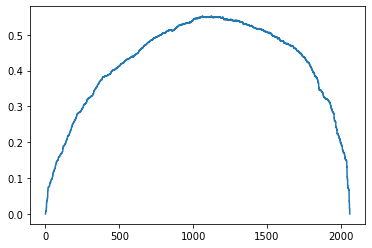

In [39]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]


from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

plt.plot(tpr-fpr);

In [46]:
y_pred_optimal = y_pred_proba >= 0.51
print(f1_score(y_val, y_pred_optimal))
print(classification_report(y_val, y_pred_optimal))

0.6378573036236778
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      6416
           1       0.58      0.70      0.64      2015

    accuracy                           0.81      8431
   macro avg       0.74      0.77      0.75      8431
weighted avg       0.82      0.81      0.81      8431



In [47]:
test_raw = pd.read_csv(url_test)
submission = pd.read_csv(url_submission)

test = engineer(test_raw)
trainer = engineer(train_raw)

X_trainer = trainer[features]
y_trainer = trainer[target]

pipe.fit(X_trainer, y_trainer)

y_pred_trainer = pipe.predict(X_trainer)
y_pred_trainer_proba = pipe.predict_proba(X_trainer)[:, 1]
y_pred_trainer_optimal = y_pred_trainer_proba >= 0.51
print(f1_score(y_trainer, y_pred_trainer_optimal))

0.6395467221459874


In [55]:
pipe2 = make_pipeline(
    TargetEncoder(cols = target_col, smoothing = 45),
    CatBoostEncoder(cols = cat_col, a = 1, sigma = 0),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced', criterion = "entropy",
                          n_estimators = 512, max_depth = 12, min_samples_leaf = 6)
)

pipe2.fit(X_train,y_train)

print('훈련 정확도: ', pipe2.score(X_train, y_train))
print('검증 정확도: ', pipe2.score(X_val, y_val))

y_pred_val = pipe2.predict(X_val)
y_pred_train = pipe2.predict(X_train)
print('훈련 f1 score :',f1_score(y_train, y_pred_train))
print('검증 f1 score :',f1_score(y_val, y_pred_val))


훈련 정확도:  0.8183435637398808
검증 정확도:  0.8150871782706678
훈련 f1 score : 0.6440855217290262
검증 f1 score : 0.638031112143023


In [53]:
pipe2.fit(X_trainer, y_trainer)

y_pred_trainer = pipe2.predict(X_trainer)
y_pred_trainer_proba = pipe2.predict_proba(X_trainer)[:, 1]
y_pred_trainer_optimal = y_pred_trainer_proba >= 0.5
print(f1_score(y_trainer, y_pred_trainer_optimal))

0.6464309840126097


In [54]:
y_pred_test = pipe2.predict(test)
y_pred_test_proba = pipe2.predict_proba(test)[:, 1]
y_pred_test_optimal = y_pred_test_proba >= 0.5

submission['vacc_h1n1_f'] = y_pred_test_optimal
submission.to_csv("submission10.csv", index=False)

우선 randomized search를 통해 큰 틀에서 최적의 파라미터를 찾고,  
grid search를 통해 미세 조정을 하였으나,   
이전에 수작업을 통해 작업했던 것보다 시간도 오래 걸리고 훈련+검증 세트에서나 캐글에서나 점수가 낮았다.    

어쨋든 수작업을 통해 느꼈던 것은 encoder의 parameter보다 모델의 parameter가 더 많은 영향을 주었다는 것이다. 

그리고 n_estimators나 depth, leaf가 증가하면 그만큼 모델도 복잡해져 성능도 증가할 것이라 예상했지만, 그렇지 않았다는 점을 알 수 있었다. 

가장 확실하게 최적의 파라미터를 찾기 위해서는 randomized search 보단 처음부터 grid search를 통해 값을 좁혀나가는 방식이 좋을 것 같다. 
(하지만 너무 오래걸려서 시도해보지는 못하겠다...)